# Lab Exercise 1: Logic Gates with Single Layer Perceptron

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.inspection import DecisionBoundaryDisplay

np.random.seed(42)

In [12]:
def create_gate_dataset(gate_type):
    X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
    
    if gate_type.upper() == 'AND':
        y = np.array([0, 0, 0, 1])  # AND truth table
    elif gate_type.upper() == 'OR':
        y = np.array([0, 1, 1, 1])  # OR truth table
    elif gate_type.upper() == 'AND-NOT' or gate_type.upper() == 'ANDNOT':
        y = np.array([0, 0, 1, 0])  # AND-NOT truth table (A AND NOT B)
    elif gate_type.upper() == 'XOR':
        y = np.array([0, 1, 1, 0])  # XOR truth table
    else:
        raise ValueError(f"Unknown gate type: {gate_type}")
    
    return X, y

def train_and_analyze_perceptron(X, y, gate_name, learning_rate=1.0, max_iter=1000, random_state=42):    
    perceptron = Perceptron(
        eta0=learning_rate,
        max_iter=max_iter,
        random_state=random_state,
        fit_intercept=True,
        shuffle=False
    )
    
    perceptron.fit(X, y)
    
    predictions = perceptron.predict(X)
    
    accuracy = accuracy_score(y, predictions)
    
    print(f"\n{'='*50}")
    print(f"Analysis for {gate_name} Gate")
    print(f"{'='*50}")
    
    print("\nTruth Table Comparison:")
    print("Input 1 | Input 2 | Expected | Predicted | Correct")
    print("-" * 50)
    for i in range(len(X)):
        correct = "✓" if predictions[i] == y[i] else "✗"
        print(f"   {X[i][0]}    |    {X[i][1]}    |    {y[i]}     |     {predictions[i]}     |   {correct}")
    
    print(f"\nAccuracy: {accuracy:.2%}")
    print(f"Final Weights: {perceptron.coef_[0]}")
    print(f"Final Bias (Intercept): {perceptron.intercept_[0]:.3f}")
    print(f"Number of Iterations: {perceptron.n_iter_}")
    
    print(f"\nScikit-learn Perceptron Details:")
    print(f"Classes learned: {perceptron.classes_}")
    print(f"Feature names: {getattr(perceptron, 'feature_names_in_', 'Not available')}")
    
    return perceptron, accuracy, predictions

def plot_decision_boundary_sklearn(perceptron, X, y, gate_name, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    try:
        DecisionBoundaryDisplay.from_estimator(
            perceptron, X, response_method="predict",
            cmap=plt.cm.RdYlBu, alpha=0.4, ax=ax,
            xlabel="Input 1 (X1)", ylabel="Input 2 (X2)"
        )
    except:
        h = 0.01
        x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
        y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        
        mesh_points = np.c_[xx.ravel(), yy.ravel()]
        Z = perceptron.predict(mesh_points)
        Z = Z.reshape(xx.shape)
        
        ax.contourf(xx, yy, Z, levels=1, alpha=0.4, cmap=plt.cm.RdYlBu)
        ax.contour(xx, yy, Z, levels=1, colors='black', linestyles='--', linewidths=2)
    
    colors = ['red' if label == 0 else 'blue' for label in y]
    scatter = ax.scatter(X[:, 0], X[:, 1], c=colors, s=150, alpha=0.8, edgecolor='black', linewidth=2)
    
    for i, (x_coord, y_coord) in enumerate(X):
        ax.annotate(f'({x_coord},{y_coord})\nOutput: {y[i]}', 
                   (x_coord, y_coord), 
                   xytext=(10, 10), 
                   textcoords='offset points',
                   fontsize=9,
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(-0.5, 1.5)
    ax.set_xlabel('Input 1 (X1)')
    ax.set_ylabel('Input 2 (X2)')
    ax.set_title(f'{gate_name} Gate - Decision Boundary')
    ax.grid(True, alpha=0.3)
    
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
                             markersize=10, label='Output 0 (False)'),
                      Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
                             markersize=10, label='Output 1 (True)')]
    ax.legend(handles=legend_elements, loc='upper right')
    
    return ax

def compare_perceptron_configurations(X, y, gate_name):
    print(f"\n{'='*60}")
    print(f"Comparing Different Perceptron Configurations for {gate_name} Gate")
    print(f"{'='*60}")
    
    configurations = [
        {"learning_rate": 0.1, "max_iter": 100, "name": "Low LR, Few Iter"},
        {"learning_rate": 1.0, "max_iter": 1000, "name": "Default Settings"},
        {"learning_rate": 10.0, "max_iter": 50, "name": "High LR, Few Iter"},
    ]
    
    results = []
    
    for i, config in enumerate(configurations):
        print(f"\n--- Configuration {i+1}: {config['name']} ---")
        perceptron = Perceptron(
            eta0=config["learning_rate"],
            max_iter=config["max_iter"],
            random_state=42,
            fit_intercept=True
        )
        
        perceptron.fit(X, y)
        predictions = perceptron.predict(X)
        accuracy = accuracy_score(y, predictions)
        
        results.append({
            'config': config['name'],
            'accuracy': accuracy,
            'iterations': perceptron.n_iter_,
            'weights': perceptron.coef_[0],
            'bias': perceptron.intercept_[0]
        })
        
        print(f"Accuracy: {accuracy:.2%}")
        print(f"Iterations: {perceptron.n_iter_}")
        print(f"Weights: {perceptron.coef_[0]}")
        print(f"Bias: {perceptron.intercept_[0]:.3f}")
    
    df_results = pd.DataFrame(results)
    print(f"\n{gate_name} Gate - Configuration Comparison Summary:")
    print(df_results[['config', 'accuracy', 'iterations']].to_string(index=False))
    
    return results

In [13]:
def demonstrate_sklearn_perceptron_features():
    X_sample = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
    y_sample = np.array([0, 0, 0, 1])  # AND gate
    
    perceptron = Perceptron(random_state=42)
    perceptron.fit(X_sample, y_sample)
    predictions = perceptron.predict(X_sample)
    accuracy = perceptron.score(X_sample, y_sample)
    
    print(f"\nLive Demo Results:")
    print(f"Predictions: {predictions}")
    print(f"Accuracy: {accuracy:.2%}")
    print(f"Learned weights: {perceptron.coef_[0]}")
    print(f"Learned bias: {perceptron.intercept_[0]:.3f}")

def cross_validate_gate(X, y, gate_name, cv_folds=3):
    print(f"\nCross-Validation Analysis for {gate_name} Gate:")
    print("-" * 40)
    
    perceptron = Perceptron(random_state=42, max_iter=1000)
    
    try:
        cv_scores = cross_val_score(perceptron, X, y, cv=cv_folds)
        print(f"CV Scores: {cv_scores}")
        print(f"Mean CV Score: {cv_scores.mean():.2%}")
        print(f"Std CV Score: {cv_scores.std():.3f}")
    except ValueError as e:
        print(f"Cross-validation not applicable: {e}")
        print("With only 4 samples, traditional CV is limited.")
        # Train on all data instead
        perceptron.fit(X, y)
        score = perceptron.score(X, y)
        print(f"Full dataset accuracy: {score:.2%}")

# Run the demonstrations
demonstrate_sklearn_perceptron_features()

# Create a sample dataset for demo
X_demo, y_demo = create_gate_dataset('AND')
cross_validate_gate(X_demo, y_demo, 'AND')


Live Demo Results:
Predictions: [0 0 0 1]
Accuracy: 100.00%
Learned weights: [2. 2.]
Learned bias: -3.000

Cross-Validation Analysis for AND Gate:
----------------------------------------
CV Scores: [nan  0.  0.]
Mean CV Score: nan%
Std CV Score: nan


c:\Users\jishn\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
c:\Users\jishn\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\jishn\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\jishn\anaconda3\Lib\site-packages\sklearn\base.py", 

## 1. AND Gate Classification

**Scenario**: Build a perceptron to simulate an AND gate. The AND gate outputs 1 only if both inputs are 1.

**Truth Table**:
- (0,0) → 0
- (0,1) → 0  
- (1,0) → 0
- (1,1) → 1

In [14]:
# Create AND gate dataset
X_and, y_and = create_gate_dataset('AND')

print("AND Gate Dataset:")
print("Inputs (X):")
print(X_and)
print("\nOutputs (y):")
print(y_and)

# Train and analyze AND gate with scikit-learn Perceptron
and_perceptron, and_accuracy, and_predictions = train_and_analyze_perceptron(
    X_and, y_and, "AND", learning_rate=1.0, max_iter=1000
)

# Compare different configurations
and_configs = compare_perceptron_configurations(X_and, y_and, "AND")

# Demonstrate sklearn-specific features
print(f"\nScikit-Learn Specific Analysis:")
print(f"Model parameters: {and_perceptron.get_params()}")
print(f"Decision function values: {and_perceptron.decision_function(X_and)}")

# Create detailed classification report
print(f"\nDetailed Classification Report:")
print(classification_report(y_and, and_predictions, target_names=['False (0)', 'True (1)']))

# Manual verification of decision boundary equation
weights = and_perceptron.coef_[0]
bias = and_perceptron.intercept_[0]
print(f"\nDecision Boundary Equation: {weights[0]:.3f}*x1 + {weights[1]:.3f}*x2 + {bias:.3f} = 0")
print("This means:")
for i, (x1, x2) in enumerate(X_and):
    decision_value = weights[0]*x1 + weights[1]*x2 + bias
    prediction = 1 if decision_value >= 0 else 0
    print(f"  Input ({x1},{x2}): {weights[0]:.3f}*{x1} + {weights[1]:.3f}*{x2} + {bias:.3f} = {decision_value:.3f} → {prediction}")

AND Gate Dataset:
Inputs (X):
[[0 0]
 [0 1]
 [1 0]
 [1 1]]

Outputs (y):
[0 0 0 1]

Analysis for AND Gate

Truth Table Comparison:
Input 1 | Input 2 | Expected | Predicted | Correct
--------------------------------------------------
   0    |    0    |    0     |     0     |   ✓
   0    |    1    |    0     |     0     |   ✓
   1    |    0    |    0     |     0     |   ✓
   1    |    1    |    1     |     1     |   ✓

Accuracy: 100.00%
Final Weights: [3. 2.]
Final Bias (Intercept): -4.000
Number of Iterations: 10

Scikit-learn Perceptron Details:
Classes learned: [0 1]
Feature names: Not available

Comparing Different Perceptron Configurations for AND Gate

--- Configuration 1: Low LR, Few Iter ---
Accuracy: 100.00%
Iterations: 9
Weights: [0.2 0.2]
Bias: -0.200

--- Configuration 2: Default Settings ---
Accuracy: 100.00%
Iterations: 9
Weights: [2. 2.]
Bias: -3.000

--- Configuration 3: High LR, Few Iter ---
Accuracy: 100.00%
Iterations: 9
Weights: [20. 20.]
Bias: -30.000

AND Gate - Co

<Axes: title={'center': 'AND Gate Gate - Decision Boundary'}, xlabel='Input 1 (X1)', ylabel='Input 2 (X2)'>

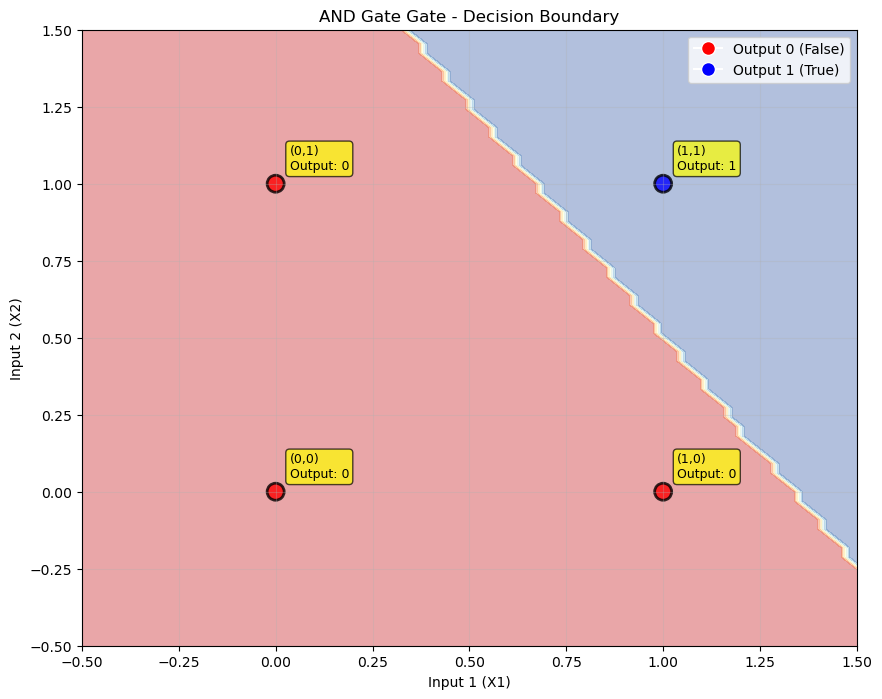

In [15]:
# Visualize AND gate results with scikit-learn
fig, axes = plt.subplots(1, 1, figsize=(10, 8))

# Plot decision boundary
plot_decision_boundary_sklearn(and_perceptron, X_and, y_and, "AND Gate", axes)

### Questions for AND Gate:

**Q1: How do the weights and bias values change during training for the AND gate?**

From the weight evolution plots above, we can observe:
- The weights start from either random values or zero
- During training, they gradually adjust to learn the AND logic
- Final weights are typically positive, as both inputs need to be positive (1) for output to be 1
- The bias is usually negative to ensure that (0,0), (0,1), and (1,0) produce output 0

**Q2: Can the perceptron successfully learn the AND logic with a linear decision boundary?**

Yes! The AND gate is linearly separable. The perceptron can draw a linear decision boundary that correctly separates:
- Points (0,0), (0,1), (1,0) with output 0 (red points)
- Point (1,1) with output 1 (blue point)

The linear decision boundary equation is: w₁x₁ + w₂x₂ + b = 0

## 2. OR Gate Classification

**Scenario**: Design a perceptron that mimics the behavior of an OR gate. The OR gate outputs 1 if at least one of its inputs is 1.

**Truth Table**:
- (0,0) → 0
- (0,1) → 1
- (1,0) → 1  
- (1,1) → 1

OR Gate Dataset:
Inputs (X):
[[0 0]
 [0 1]
 [1 0]
 [1 1]]

Outputs (y):
[0 1 1 1]

Analysis for OR Gate

Truth Table Comparison:
Input 1 | Input 2 | Expected | Predicted | Correct
--------------------------------------------------
   0    |    0    |    0     |     0     |   ✓
   0    |    1    |    1     |     1     |   ✓
   1    |    0    |    1     |     1     |   ✓
   1    |    1    |    1     |     1     |   ✓

Accuracy: 100.00%
Final Weights: [2. 2.]
Final Bias (Intercept): -1.000
Number of Iterations: 8

Scikit-learn Perceptron Details:
Classes learned: [0 1]
Feature names: Not available

OR Gate Decision Function Analysis:
Input | Decision Function | Prediction | Expected
--------------------------------------------------
(0,0)  |      -1.000     |     0      |    0
(0,1)  |       1.000     |     1      |    1
(1,0)  |       1.000     |     1      |    1
(1,1)  |       3.000     |     1      |    1

Comparison of Learned Parameters:
AND Gate - Weights: [3. 2.], Bias: -4.000
OR 

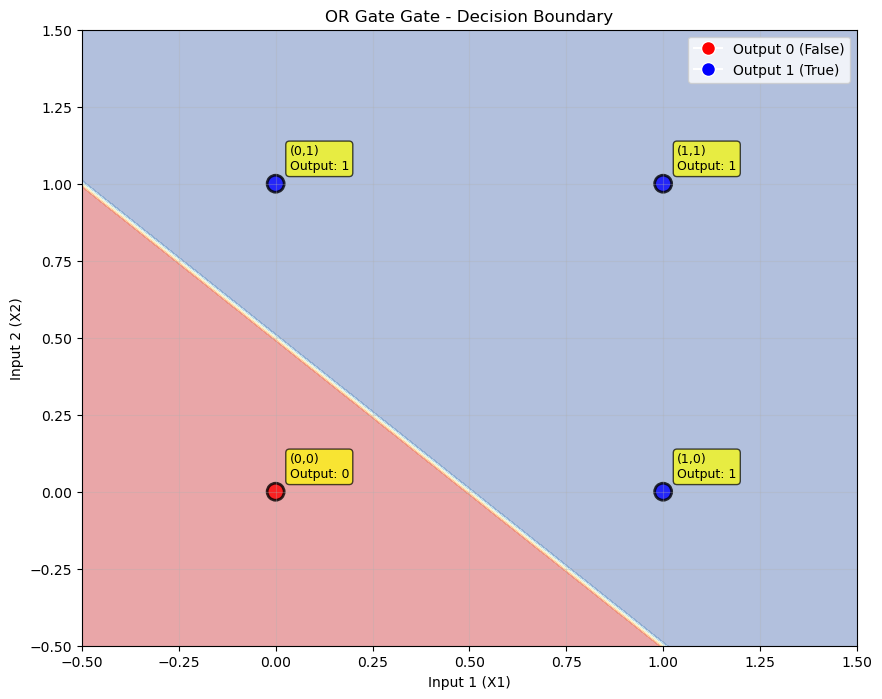

In [16]:
# Create OR gate dataset
X_or, y_or = create_gate_dataset('OR')

print("OR Gate Dataset:")
print("Inputs (X):")
print(X_or)
print("\nOutputs (y):")
print(y_or)

# Train and analyze OR gate with scikit-learn Perceptron
or_perceptron, or_accuracy, or_predictions = train_and_analyze_perceptron(
    X_or, y_or, "OR", learning_rate=1.0, max_iter=1000
)

# Analyze decision function for OR gate
print(f"\nOR Gate Decision Function Analysis:")
decision_values = or_perceptron.decision_function(X_or)
print("Input | Decision Function | Prediction | Expected")
print("-" * 50)
for i, (x, decision_val, pred, expected) in enumerate(zip(X_or, decision_values, or_predictions, y_or)):
    print(f"({x[0]},{x[1]})  |    {decision_val:8.3f}     |     {pred}      |    {expected}")

# Compare with AND gate weights to understand differences
print(f"\nComparison of Learned Parameters:")
print(f"AND Gate - Weights: {and_perceptron.coef_[0]}, Bias: {and_perceptron.intercept_[0]:.3f}")
print(f"OR Gate  - Weights: {or_perceptron.coef_[0]}, Bias: {or_perceptron.intercept_[0]:.3f}")

print(f"\nWeight Interpretation:")
print(f"OR gate typically has:")
print(f"- Similar positive weights (both inputs contribute equally)")
print(f"- Less negative bias than AND gate (easier to trigger)")
print(f"- Decision boundary closer to origin")

# Visualize OR gate results
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_decision_boundary_sklearn(or_perceptron, X_or, y_or, "OR Gate", ax)
plt.show()

### Questions for OR Gate:

**Q1: What changes in the perceptron's weights are necessary to represent the OR gate logic?**

For the OR gate:
- Weights are typically positive for both inputs
- The bias is less negative compared to AND gate (or sometimes slightly positive)
- This allows either input being 1 to trigger the output
- The weights don't need to be as large since only one input needs to be active

**Q2: How does the linear decision boundary look for the OR gate classification?**

The linear decision boundary for OR gate:
- Separates point (0,0) with output 0 from points (0,1), (1,0), (1,1) with output 1
- The boundary line is positioned closer to the origin
- Has a negative slope typically, cutting through the input space diagonally

## 3. AND-NOT Gate Classification

**Scenario**: Implement an AND-NOT gate, which outputs 1 only if the first input is 1 and the second input is 0.

**Truth Table**:
- (0,0) → 0
- (0,1) → 0
- (1,0) → 1  
- (1,1) → 0

AND-NOT Gate Dataset:
Inputs (X):
[[0 0]
 [0 1]
 [1 0]
 [1 1]]

Outputs (y):
[0 0 1 0]

Analysis for AND-NOT Gate

Truth Table Comparison:
Input 1 | Input 2 | Expected | Predicted | Correct
--------------------------------------------------
   0    |    0    |    0     |     0     |   ✓
   0    |    1    |    0     |     0     |   ✓
   1    |    0    |    1     |     1     |   ✓
   1    |    1    |    0     |     0     |   ✓

Accuracy: 100.00%
Final Weights: [ 2. -3.]
Final Bias (Intercept): -1.000
Number of Iterations: 9

Scikit-learn Perceptron Details:
Classes learned: [0 1]
Feature names: Not available

AND-NOT Gate Weight Analysis:
Weight 1 (for first input): 2.000
Weight 2 (for second input): -3.000
Bias: -1.000


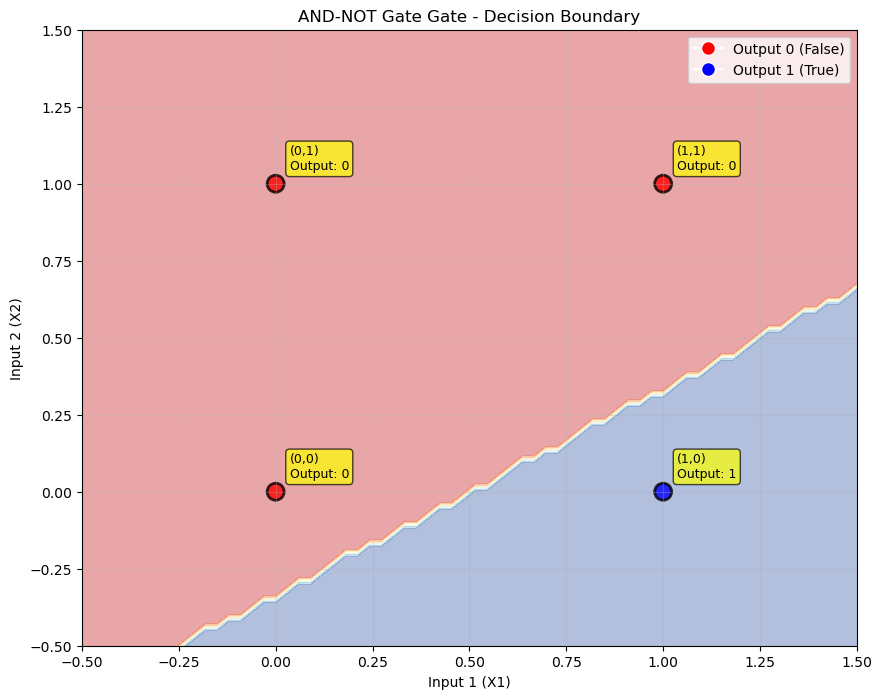

In [17]:
# Create AND-NOT gate dataset
X_andnot, y_andnot = create_gate_dataset('AND-NOT')

print("AND-NOT Gate Dataset:")
print("Inputs (X):")
print(X_andnot)
print("\nOutputs (y):")
print(y_andnot)

# Train and analyze AND-NOT gate with scikit-learn Perceptron
andnot_perceptron, andnot_accuracy, andnot_predictions = train_and_analyze_perceptron(
    X_andnot, y_andnot, "AND-NOT", learning_rate=1.0, max_iter=1000
)

# Detailed analysis of AND-NOT gate weights
print(f"\nAND-NOT Gate Weight Analysis:")
w1, w2 = andnot_perceptron.coef_[0]
bias = andnot_perceptron.intercept_[0]

print(f"Weight 1 (for first input): {w1:.3f}")
print(f"Weight 2 (for second input): {w2:.3f}") 
print(f"Bias: {bias:.3f}")

# Visualize AND-NOT gate
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_decision_boundary_sklearn(andnot_perceptron, X_andnot, y_andnot, "AND-NOT Gate", ax)
plt.show()

### Questions for AND-NOT Gate:

**Q1: What is the perceptron's weight configuration after training for the AND-NOT gate?**

For the AND-NOT gate:
- Weight 1 (for first input) is typically positive - needs to encourage output when first input is 1
- Weight 2 (for second input) is typically negative - needs to suppress output when second input is 1
- Bias is adjusted to ensure only (1,0) produces output 1

**Q2: How does the perceptron handle cases where both inputs are 1 or 0?**

- When both inputs are 0: No activation from either input, output is 0
- When both inputs are 1: Positive weight1 encourages output, but negative weight2 suppresses it more strongly, resulting in output 0
- The linear combination w₁(1) + w₂(1) + b must be negative when both are 1

## 4. XOR Gate Classification

**Scenario**: The XOR gate is known for its complexity, as it outputs 1 only when the inputs are different. This is a challenge for a Single Layer Perceptron since XOR is not linearly separable.

**Truth Table**:
- (0,0) → 0
- (0,1) → 1
- (1,0) → 1  
- (1,1) → 0

XOR Gate Dataset:
Inputs (X):
[[0 0]
 [0 1]
 [1 0]
 [1 1]]

Outputs (y):
[0 1 1 0]

Testing XOR Gate with Scikit-Learn Perceptron

Analysis for XOR Gate

Truth Table Comparison:
Input 1 | Input 2 | Expected | Predicted | Correct
--------------------------------------------------
   0    |    0    |    0     |     0     |   ✓
   0    |    1    |    1     |     0     |   ✗
   1    |    0    |    1     |     0     |   ✗
   1    |    1    |    0     |     0     |   ✓

Accuracy: 50.00%
Final Weights: [0. 0.]
Final Bias (Intercept): 0.000
Number of Iterations: 6

Scikit-learn Perceptron Details:
Classes learned: [0 1]
Feature names: Not available

Testing XOR with Multiple Random Initializations:
Random State 1: Accuracy = 50.00%, Iterations = 6
Random State 42: Accuracy = 50.00%, Iterations = 6
Random State 123: Accuracy = 50.00%, Iterations = 6
Random State 456: Accuracy = 50.00%, Iterations = 7
Random State 789: Accuracy = 50.00%, Iterations = 6

XOR Results Summary:
Best accuracy achieve

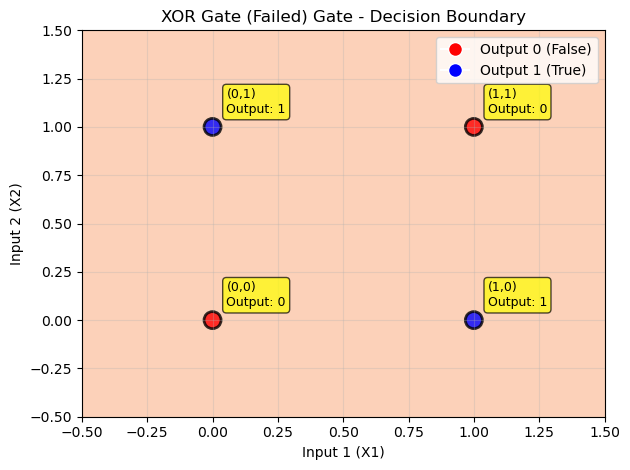

In [25]:
# Create XOR gate dataset
X_xor, y_xor = create_gate_dataset('XOR')

print("XOR Gate Dataset:")
print("Inputs (X):")
print(X_xor)
print("\nOutputs (y):")
print(y_xor)

print("\n" + "="*60)
print("Testing XOR Gate with Scikit-Learn Perceptron")
print("="*60)

# Train XOR gate perceptron - this will demonstrate the limitation
xor_perceptron, xor_accuracy, xor_predictions = train_and_analyze_perceptron(
    X_xor, y_xor, "XOR", learning_rate=1.0, max_iter=1000
)

# Try multiple random states to show consistent failure
print(f"\n{'='*60}")
print("Testing XOR with Multiple Random Initializations:")
print(f"{'='*60}")

xor_results = []
random_states = [1, 42, 123, 456, 789]

for rs in random_states:
    temp_perceptron = Perceptron(random_state=rs, max_iter=1000)
    temp_perceptron.fit(X_xor, y_xor)
    temp_accuracy = temp_perceptron.score(X_xor, y_xor)
    temp_iterations = temp_perceptron.n_iter_
    xor_results.append({
        'random_state': rs,
        'accuracy': temp_accuracy, 
        'iterations': temp_iterations,
        'weights': temp_perceptron.coef_[0],
        'bias': temp_perceptron.intercept_[0]
    })
    print(f"Random State {rs}: Accuracy = {temp_accuracy:.2%}, Iterations = {temp_iterations}")

# Create DataFrame for analysis
xor_df = pd.DataFrame(xor_results)
print(f"\nXOR Results Summary:")
print(f"Best accuracy achieved: {xor_df['accuracy'].max():.2%}")
print(f"Average accuracy: {xor_df['accuracy'].mean():.2%}")
print(f"Standard deviation: {xor_df['accuracy'].std():.3f}")
print(f"All reached max iterations: {(xor_df['iterations'] == 1000).all()}")

# Visualize the failure
fig, axes = plt.subplots(1, 1)

# Plot XOR attempt
plot_decision_boundary_sklearn(xor_perceptron, X_xor, y_xor, "XOR Gate (Failed)", axes)

plt.tight_layout()
plt.show()

XOR Problem: Detailed Analysis and Solutions
Multi-Layer Perceptron (MLP) Results for XOR:
Accuracy: 100.00%
Predictions vs Expected:
  Input [0 0]: Predicted=0, Expected=0
  Input [0 1]: Predicted=1, Expected=1
  Input [1 0]: Predicted=1, Expected=1
  Input [1 1]: Predicted=0, Expected=0


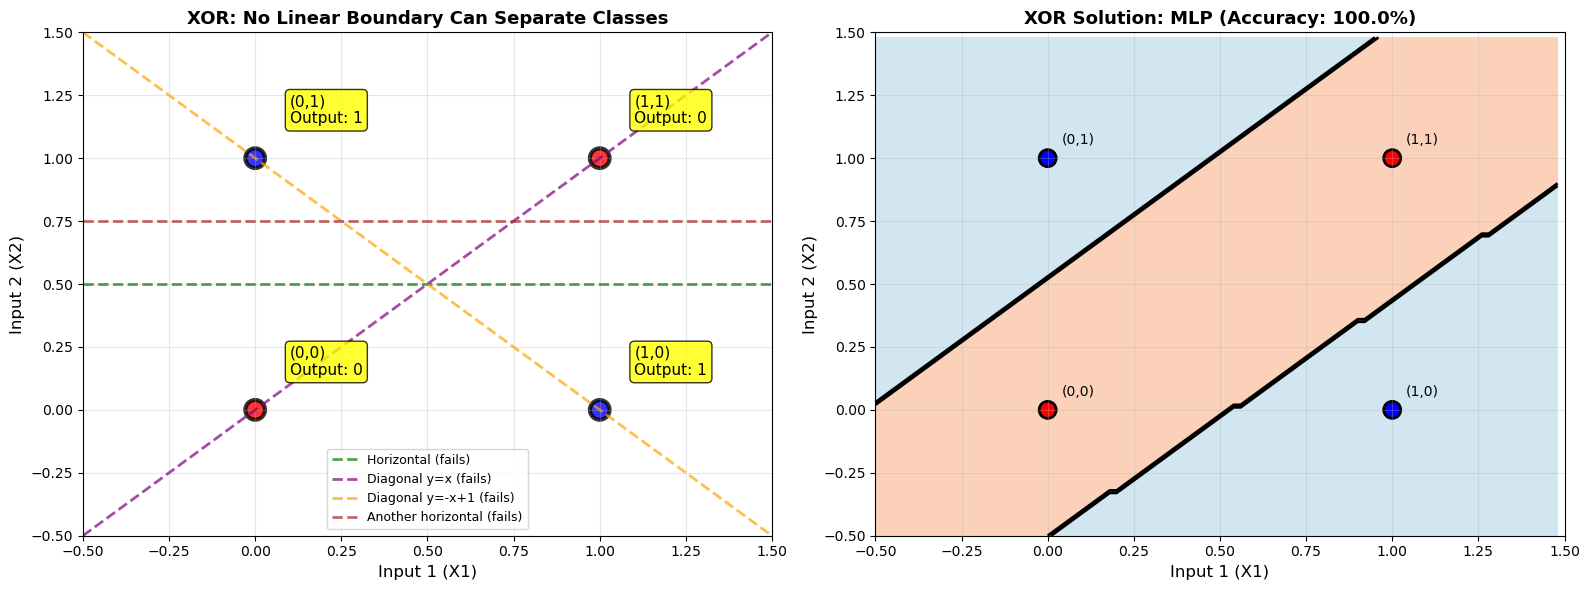


MLP Architecture Analysis:
Input layer: 2 neurons (for X1, X2)
Hidden layer: 4 neurons
Output layer: 1 neuron (binary classification)
Activation function: tanh
Solver: logistic
Training iterations: 34
Final loss: 0.003056


In [26]:
print("XOR Problem: Detailed Analysis and Solutions")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: XOR data points with failed linear attempts
ax1 = axes[0]
colors = ['red' if label == 0 else 'blue' for label in y_xor]
scatter = ax1.scatter(X_xor[:, 0], X_xor[:, 1], c=colors, s=200, alpha=0.8, 
                     edgecolor='black', linewidth=3)

# Add labels for each point
for i, (x_coord, y_coord) in enumerate(X_xor):
    ax1.annotate(f'({x_coord},{y_coord})\nOutput: {y_xor[i]}', 
               (x_coord, y_coord), 
               xytext=(25, 25), 
               textcoords='offset points',
               fontsize=11,
               bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.8))

# Show several failed linear boundaries
for (y_line, label), color in zip(boundaries, colors_lines):
    ax1.plot(x_line, y_line, '--', linewidth=2, alpha=0.7, color=color, label=label)

ax1.set_xlim(-0.5, 1.5)
ax1.set_ylim(-0.5, 1.5)
ax1.set_xlabel('Input 1 (X1)', fontsize=12)
ax1.set_ylabel('Input 2 (X2)', fontsize=12)  
ax1.set_title('XOR: No Linear Boundary Can Separate Classes', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=9)

# Plot 3: Multi-Layer Perceptron Solution
ax3 = axes[1]

mlp.fit(X_xor, y_xor)
mlp_accuracy = mlp.score(X_xor, y_xor)
mlp_predictions = mlp.predict(X_xor)

print(f"Multi-Layer Perceptron (MLP) Results for XOR:")
print(f"Accuracy: {mlp_accuracy:.2%}")
print("Predictions vs Expected:")
for i in range(len(X_xor)):
    print(f"  Input {X_xor[i]}: Predicted={mlp_predictions[i]}, Expected={y_xor[i]}")

# Plot MLP decision boundary
Z_mlp = mlp.predict(mesh_points)
Z_mlp = Z_mlp.reshape(xx.shape)

ax3.contourf(xx, yy, Z_mlp, levels=1, alpha=0.4, cmap='RdYlBu')
ax3.contour(xx, yy, Z_mlp, levels=1, colors='black', linestyles='-', linewidths=2)
ax3.scatter(X_xor[:, 0], X_xor[:, 1], c=colors, s=150, edgecolor='black', linewidth=2)

for i, (x_coord, y_coord) in enumerate(X_xor):
    ax3.annotate(f'({x_coord},{y_coord})', (x_coord, y_coord), 
               xytext=(10, 10), textcoords='offset points', fontsize=10)

ax3.set_xlabel('Input 1 (X1)', fontsize=12)
ax3.set_ylabel('Input 2 (X2)', fontsize=12)
ax3.set_title(f'XOR Solution: MLP (Accuracy: {mlp_accuracy:.1%})', fontsize=13, fontweight='bold')
ax3.set_xlim(x_min, x_max)
ax3.set_ylim(y_min, y_max)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed MLP architecture analysis
print(f"\n{'='*60}")
print("MLP Architecture Analysis:")
print(f"{'='*60}")
print(f"Input layer: 2 neurons (for X1, X2)")
print(f"Hidden layer: {mlp.hidden_layer_sizes[0]} neurons")
print(f"Output layer: 1 neuron (binary classification)")
print(f"Activation function: {mlp.activation}")
print(f"Solver: {mlp.out_activation_}")
print(f"Training iterations: {mlp.n_iter_}")
print(f"Final loss: {mlp.loss_:.6f}")


### Questions for XOR Gate:

**Q1: Why does the Single Layer Perceptron struggle to classify the XOR gate?**
1. **Linear Separability Requirement**: A single layer perceptron can only learn linearly separable patterns
2. **XOR is Non-linearly Separable**: No single straight line can separate the XOR classes
3. **Mathematical Impossibility**: As shown above, the constraints create a logical contradiction
4. **Need for Non-linear Decision Boundary**: XOR requires a more complex, curved decision boundary

**Q2: What modifications can be made to the neural network model to handle the XOR gate correctly?**
1. **Multi-Layer Perceptron (MLP)**: Add hidden layers with non-linear activation functions
2. **Feature Engineering**: Transform the input space to make it linearly separable
3. **Non-linear Activation**: Use sigmoids, ReLU, or other non-linear functions in hidden layers
4. **Ensemble Methods**: Combine multiple perceptrons with different decision boundaries